Key features:
- Model: UNet
    - simple Unet structure with skip connections, with 2 conv block per layer
- Dataset: Filtered out 11 sample that did not include the target 'blood_vessel' class.
- Cyclic training: Based on Leslie N. Smith's paper (https://arxiv.org/pdf/1506.01186) and torch implementation (https://github.com/davidtvs/pytorch-lr-finder)
- Gradient Accumulation: Although I didn't experienced memory saturation with batch size of 16 or smaller, still it can enhance training speed and reduce memory usage.
- Data augmentation
- Combined loss (BCE + Dice loss)

## Imports

In [1]:
import os
import gc
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from datetime import datetime
from tqdm import tqdm, notebook
import albumentations as A

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch.nn.functional as F
from torchinfo import summary

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 999)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated

  "class": algorithms.Blowfish,


cuda


In [2]:
# !pip install /kaggle/input/torch-lr-finder/torch_lr_finder-0.2.1-py3-none-any.whl
from torch_lr_finder import LRFinder

## Data loading

In [3]:
class HubMap_Dataset(Dataset):
    def __init__(self, img_path, labels_file, metadata_file, augmentation=None):
        self.image_dir = img_path
        self.labels_file = labels_file
        self.metadata_file = metadata_file
        self.augmentation = augmentation

        # Processing JSON data to create a pandas df        
        with open(labels_file) as json_file:
            json_list = list(json_file)

        dataset = []
        for json_str in notebook.tqdm(json_list, desc="Reading Json Data"):
            result = json.loads(json_str)
            annotations = result['annotations']
            
            for ann in annotations:
                if ann["type"] != "blood_vessel":
                    continue
                row = {
                    "id": result["id"],
                    "coordinates": ann["coordinates"],
                }
                dataset.append(row)
        
        self.dataset = pd.DataFrame(dataset, columns=["id","coordinates"])
    
    def coordinates_to_mask(self, image_id):
        """ Create a combined mask containing all polygons. """
        all_filled_masks = np.zeros((512, 512, 1), dtype=np.uint8)
        annotations = self.dataset[self.dataset['id'] == image_id]
        for _, row in annotations.iterrows():
            coordinates = np.array(row["coordinates"])
            all_filled_masks = cv2.fillPoly(all_filled_masks, [coordinates], 1)
        return all_filled_masks

    def __len__(self):
        return len(self.dataset['id'].unique())

    def __getitem__(self, idx):
        unique_ids = self.dataset['id'].unique()
        img_id = unique_ids[idx]
        image_path = f"{self.image_dir}/{img_id}.tif"
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB) # cv2 reads in h,w,c                        
        mask = self.coordinates_to_mask(image_id=img_id)
                        
        # Augment data
        if self.augmentation is not None:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)
        image = np.array(image) / 255.0
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) # c,h,w
        
        return image, mask, img_id


In [4]:
base_path = "./data/hubmap_data"
images_folder = base_path + "/train/"
labels_path = base_path + "/polygons.jsonl"
metadata_path = base_path + "/tile_meta.csv"

augs = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.PiecewiseAffine(scale=(0.01, 0.05), p=1),
        A.GaussianBlur(blur_limit=(3, 3), p=1),
    ], p=0.5),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=1),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),
        A.CLAHE(clip_limit=2.0, p=1), # equalize colors based on histogram
    ], p=0.5),
])

HMD = HubMap_Dataset(img_path=images_folder, labels_file=labels_path, metadata_file=metadata_path, augmentation=augs)
print(f"Number of ID-s removed, where 'blood_vessel' were missing: {1633-len(HMD)}")
val_len = int(0.2*len(HMD))
lengths = [len(HMD)-val_len, val_len]
train_set, val_set = torch.utils.data.random_split(HMD, lengths)
print(f"train set: {len(train_set)}, validation set: {len(val_set)}")


C:\Users\BenceTaro\AppData\Roaming\Python\Python311\site-packages\albumentations\augmentations\geometric\transforms.py:1071: UserWarning: This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.

  warn("This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.")


Reading Json Data:   0%|          | 0/1633 [00:00<?, ?it/s]

Number of ID-s removed, where 'blood_vessel' were missing: 11

train set: 1298, validation set: 324


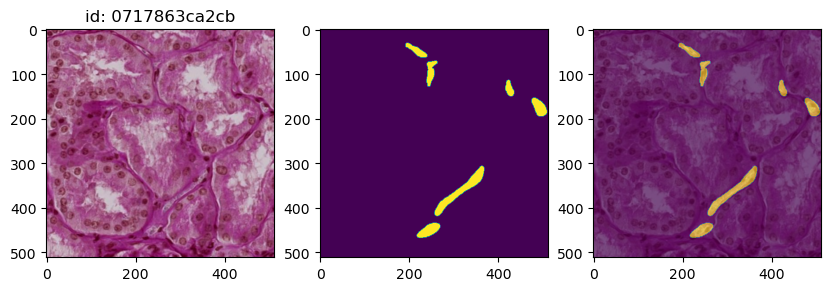

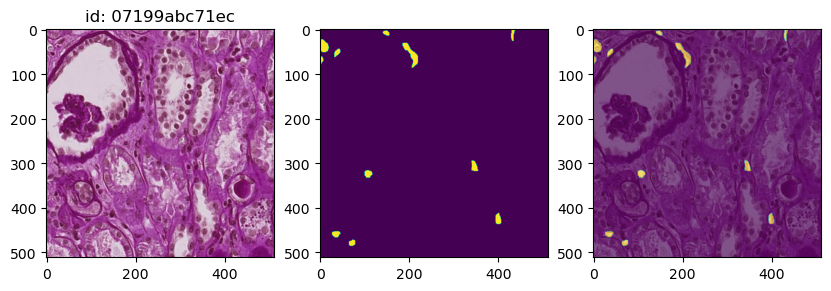

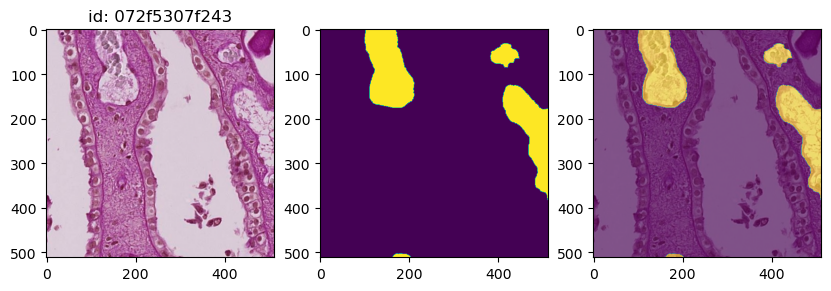

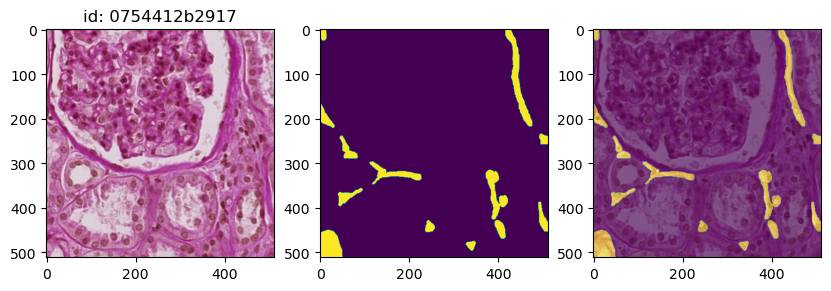

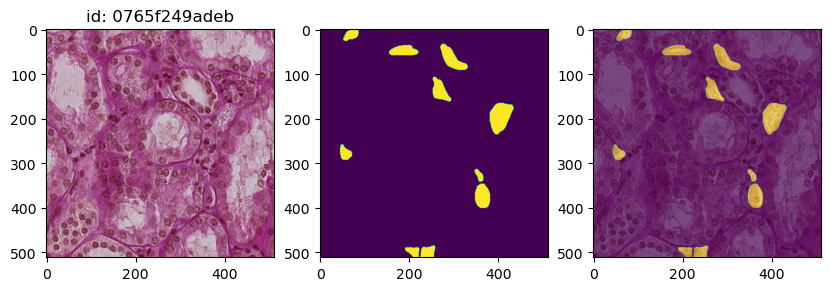

In [6]:
# Visualize samples
samples = [HMD[i] for i in range(40,45)]

for sample in samples:
    masks = sample[1].squeeze(0)
    image = sample[0].permute(1,2,0).numpy()

    fig, axs = plt.subplots(1,3,figsize=(10,8))
    axs[0].imshow(image)    
    axs[0].set_title(f"id: {sample[2]}")
    axs[1].imshow(masks)
    axs[2].imshow(image)
    axs[2].imshow(masks, alpha=0.6)
    plt.show()

## Model

In [6]:
# # could be better than default(uniform)
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, in_filters=16, num_classes=4):
        super().__init__()

        self.num_classes = num_classes

        # Donwsample
        self.encoder1 = ConvBlock(in_channels, in_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(in_filters, in_filters * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(in_filters * 2, in_filters * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(in_filters * 4, in_filters * 8)
        self.pool4 = nn.MaxPool2d(2)
        self.encoder5 = ConvBlock(in_filters * 8, in_filters * 16)
        self.pool5 = nn.MaxPool2d(2)

        # Bottom layer
        self.bottleneck = ConvBlock(in_filters * 16, in_filters * 32)

        # Upsample
        self.upconv5 = nn.ConvTranspose2d(in_filters * 32, in_filters * 16, 2, stride=2, output_padding=0)
        self.decoder5 = ConvBlock(in_filters * 32, in_filters * 16)
        self.upconv4 = nn.ConvTranspose2d(in_filters * 16, in_filters * 8, 2, stride=2)
        self.decoder4 = ConvBlock(in_filters * 16, in_filters * 8)
        self.upconv3 = nn.ConvTranspose2d(in_filters * 8, in_filters * 4, 2, stride=2)
        self.decoder3 = ConvBlock(in_filters * 8, in_filters * 4)
        self.upconv2 = nn.ConvTranspose2d(in_filters * 4, in_filters * 2, 2, stride=2)
        self.decoder2 = ConvBlock(in_filters * 4, in_filters * 2)
        self.upconv1 = nn.ConvTranspose2d(in_filters * 2, in_filters, 2, stride=2)
        self.decoder1 = ConvBlock(in_filters * 2, in_filters)

        # Classifier
        self.conv = nn.Conv2d(in_filters, num_classes, 1)
        self.apply(init_weights)

    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)
        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.encoder3(pool2)
        pool3 = self.pool3(enc3)
        enc4 = self.encoder4(pool3)
        pool4 = self.pool4(enc4)
        enc5 = self.encoder5(pool4)
        pool5 = self.pool5(enc5)

        bottleneck = self.bottleneck(pool5)

        upconv5 = self.upconv5(bottleneck)
        cat5 = torch.cat([upconv5, enc5], dim=1)
        dec5 = self.decoder5(cat5)
        upconv4 = self.upconv4(dec5)
        cat4 = torch.cat([upconv4, enc4], dim=1)
        dec4 = self.decoder4(cat4)        
        upconv3 = self.upconv3(dec4)
        cat3 = torch.cat([upconv3, enc3], dim=1)
        dec3 = self.decoder3(cat3)
        upconv2 = self.upconv2(dec3)
        cat2 = torch.cat([upconv2, enc2], dim=1)
        dec2 = self.decoder2(cat2)
        upconv1 = self.upconv1(dec2)
        cat1 = torch.cat([upconv1, enc1], dim=1)
        dec1 = self.decoder1(cat1)

        return self.conv(dec1)

In [8]:
## setup config
class cfg:
    img_size = 512
    in_ch = 3
    num_classes = 1
    filters = 16
    mixed_precision = True
    batch_size = 8
    init_lr = 1e-3
    weight_decay = 1e-4
    early_stopping = 3
    epochs = 12
    repeat = 6

# Create Unet
unet_model = UNet(in_filters=cfg.filters, num_classes=cfg.num_classes)
unet_model.to(device)

summary(unet_model, input_size=(1,3,512,512), col_names=['input_size','output_size','num_params','trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
UNet                                     [1, 3, 512, 512]          [1, 1, 512, 512]          --                        True
├─ConvBlock: 1-1                         [1, 3, 512, 512]          [1, 16, 512, 512]         --                        True
│    └─Sequential: 2-1                   [1, 3, 512, 512]          [1, 16, 512, 512]         --                        True
│    │    └─Conv2d: 3-1                  [1, 3, 512, 512]          [1, 16, 512, 512]         448                       True
│    │    └─ReLU: 3-2                    [1, 16, 512, 512]         [1, 16, 512, 512]         --                        --
│    │    └─BatchNorm2d: 3-3             [1, 16, 512, 512]         [1, 16, 512, 512]         32                        True
│    │    └─Conv2d: 3-4                  [1, 16, 512, 512]         [1, 16, 512, 512]         2,320                     True
│    

## Training

In [9]:
train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False)
oneb = next(iter(train_loader))
ims, lbs, ids = oneb
print(f"images: {ims.shape, ims.dtype, ims.device}\nmasks: {lbs.shape, lbs.dtype, lbs.device}")

images: (torch.Size([8, 3, 512, 512]), torch.float32, device(type='cpu'))

masks: (torch.Size([8, 1, 512, 512]), torch.float32, device(type='cpu'))


In [10]:
def find_best_lr(model, dataloader, loss_fn, optimizer, num_iter=100):
    """ Performs a learning rate range test to find optimal lr for next training. """
    lr_finder = LRFinder(model, optimizer, loss_fn, device='cuda')
    lr_finder.range_test(dataloader, start_lr=1e-7, end_lr=1, num_iter=num_iter, step_mode='exp')
    sug_lr = lr_finder.plot(suggest_lr=True)
    lr_finder.reset()
    torch.cuda.empty_cache()
    gc.collect()
    return sug_lr

def calc_stats(labels, preds):
    """ Calculate IoU and dice score. """
    pred_class = torch.sigmoid(preds).round()
    num_correct = (pred_class == labels).sum().item()
    num_pixels = labels.numel()
    intersection = (pred_class * labels).sum().item()
    union = (pred_class + labels).sum().item() - intersection

    if union > 0:
        pixel_acc = num_correct / num_pixels * 100
        iou = intersection / union * 100
        dice_score = (2 * intersection) / ((pred_class + labels).sum().item() + 1e-8)
    else:
        pixel_acc = 0
        iou = 0        
        dice_score = 0

    return dice_score, iou, pixel_acc

def training(train_loader, valid_loader, model, loss_fn, optimizer, epochs, early_stopping, history=None, prev_val_loss=None, set_scaler=False, device="cuda"):
    
    scaler = torch.cuda.amp.GradScaler() if set_scaler else None
    early_stopping_counter = 0
    ga_target = cfg.batch_size * 3 # update in every 3 batches
    if prev_val_loss is None:
        prev_val_loss = np.Inf
    if history is None:        
        history = {
            "epoch": [],
            "train_loss": [],
            "valid_loss": [],
            "p_acc": [],
            "d_score": [],
            "iou": [],
        }    
    
    for e in range(epochs):
        # TRAINING
        model.train()
        print("-" * 40)
        print(f"EPOCH {e + 1}/{epochs}. training step...")
        train_time_1 = datetime.now()
        loss_list = []
        ga_counter = 0

        for i, data in enumerate(train_loader):
            im = data[0].to(device)
            seg_gt = data[1].to(device)

            with torch.cuda.amp.autocast(enabled=set_scaler):
                seg_pred = model.forward(im)
                loss = loss_fn(seg_pred, seg_gt) / ga_target # need normalized loss

            # Backward and accumulate gradients
            if set_scaler:
                scaler.scale(loss.mean()).backward()
            else:
                loss.backward()
            
            # Update GA counter
            ga_counter += cfg.batch_size

            # Perform the optimization step if the target accumulation size is reached
            if ga_counter >= ga_target:
                if set_scaler:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                
                optimizer.zero_grad()
                ga_counter = 0
                
            # Collect loss
            loss_list.append(loss.item() * ga_target) # append accumulated loss
            
        train_time_2 = datetime.now()- train_time_1
        print(f" - epoch training time: (hh:mm:ss:ms): {train_time_2}\n")

        # VALIDATION
        model.eval()
        print(f"EPOCH {e + 1}/{epochs}. validation step...")
        val_loss_list = []
        total_dice_scores = 0
        total_iou = 0
        total_pixel_acc = 0
        
        for i, data in enumerate(valid_loader):
            im = data[0].to(device)
            seg_gt = data[1].to(device)

            with torch.no_grad():
                seg_pred = model.forward(im)
                val_loss = loss_fn(seg_pred, seg_gt)
                val_loss_list.append(val_loss.item())
                                
                # Stats calculation
                dice_score, iou, pixel_acc = calc_stats(labels=seg_gt, preds=seg_pred)
                total_dice_scores += dice_score
                total_iou += iou
                total_pixel_acc += pixel_acc

        #  Take the avg of the collected losses and metrrics
        avg_train_loss = np.mean(loss_list)
        avg_valid_loss = np.mean(val_loss_list)
        avg_dice_scores = total_dice_scores / len(valid_loader)
        avg_iou = total_iou / len(valid_loader)
        avg_pixel_acc = total_pixel_acc / len(valid_loader)
        
        # Print out stats
        print(f"Results:")
        print(f" - Train epoch mean loss: {avg_train_loss:.4f}")
        print(f" - Valid epoch mean loss: {avg_valid_loss:.4f}\n")        
        print(f" - Dice score: {avg_dice_scores:.4f}")
        print(f" - Iou: {avg_iou:.2f}%")
        print(f" - Pixel accuracy: {avg_pixel_acc:.2f}%")
        history["epoch"].append(e + 1)
        history["train_loss"].append(avg_train_loss)
        history["valid_loss"].append(avg_valid_loss)
        history["p_acc"].append(avg_pixel_acc)
        history["d_score"].append(avg_dice_scores)
        history["iou"].append(avg_iou)
                    
        # Compare losses and save model with lower loss
        if avg_valid_loss <= prev_val_loss:
            print(f" - Lower validation loss achieved ({prev_val_loss:.4f}-->{avg_valid_loss:.4f}). Saving model...")
            best_model_state = model.state_dict()
            torch.save(best_model_state, f'./best_model_state.pth')
            prev_val_loss = avg_valid_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter +=1
            print(f" - Validation loss did not improved. Early stopping counter {early_stopping_counter}/{early_stopping}")
            if early_stopping == early_stopping_counter:
                break

        # Clear cache after epoch
        torch.cuda.empty_cache()
        gc.collect()
        
    return history, prev_val_loss


def model_trainer(train_loader, valid_loader, model, loss_fn, optimizer, epochs, early_stopping, set_scaler=False, device="cuda", repeat=5):
    
    assert (repeat>=1) & (repeat<=10), "The 'repeat' parameter must be an integer between 1 and 10."
    print(f"There will be {repeat} training iterations with {epochs} epochs each.")
    start_time = datetime.now()
    
    # Train model repeatably
    for i in range(repeat):
        print(f"\nTRAINING ITERATION {i+1}/{repeat}")
        
        if i == 0:
            history, best_val_loss = training(train_loader, valid_loader, model, loss_fn, optimizer, epochs, early_stopping, history=None, prev_val_loss=None, set_scaler=set_scaler, device=device)
        else:
            history, best_val_loss = training(train_loader, valid_loader, model, loss_fn, optimizer, epochs, early_stopping, history=history, prev_val_loss=best_val_loss, set_scaler=set_scaler, device=device)
        
        # Load current best model
        saved_model = "./best_model_state.pth"
        model.load_state_dict(torch.load(saved_model))
        
        if i != repeat-1:
            # Check the optimal lr for next training
            print()
            suggested_lr = find_best_lr(model, train_loader, loss_fn, optimizer, num_iter=100)

            if isinstance(suggested_lr, tuple) and len(suggested_lr) > 1:
                lr_value = suggested_lr[1]
            elif isinstance(suggested_lr, (float, int)):
                lr_value = suggested_lr
            else:
                print("Unexpected format for suggested learning rate.")
                lr_value = 1e-4
                
            # Update optimizer
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr_value, weight_decay=cfg.weight_decay)
            print(f"\nLearning rate for the next training: {lr_value}")

    end_time = datetime.now()-start_time
    print(f"\nAll training has finished. Time spent (hh:mm:ss:ms) - {end_time}")
            
    return model, history


In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super().__init__()
        self.smooth = smooth

    def forward(self, outputs, labels):
        pred_class = torch.sigmoid(outputs)
        intersection = (pred_class * labels).sum()
        union = pred_class.sum() + labels.sum() - intersection
        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score
        return dice_loss
    
class CombinedLoss(nn.Module):
    """ Combined loss function, utilizing BCE and Dice losses. """

    def __init__(self, weight=None, smooth=1e-8):
        super().__init__()
        self.weight = weight
        self.smooth = smooth

    def forward(self, outputs, labels):
        # Calculate BCE
        bce_loss = F.binary_cross_entropy_with_logits(outputs, labels, weight=self.weight)

        # Calculate Dice loss
        pred_class = torch.sigmoid(outputs)
        intersection = (pred_class * labels).sum()
        union = pred_class.sum() + labels.sum() - intersection
        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score

        # Combine Dice loss and BCE loss
        combined_loss = bce_loss + dice_loss
        return combined_loss

There will be 6 training iterations with 12 epochs each.



TRAINING ITERATION 1/6

----------------------------------------

EPOCH 1/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:15.351661



EPOCH 1/12. validation step...

Results:

 - Train epoch mean loss: 1.5373

 - Valid epoch mean loss: 1.4318



 - Dice score: 0.3220

 - Iou: 19.46%

 - Pixel accuracy: 90.27%

 - Lower validation loss achieved (inf-->1.4318). Saving model...

----------------------------------------

EPOCH 2/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:17.282379



EPOCH 2/12. validation step...

Results:

 - Train epoch mean loss: 1.3288

 - Valid epoch mean loss: 1.2399



 - Dice score: 0.4090

 - Iou: 26.11%

 - Pixel accuracy: 93.17%

 - Lower validation loss achieved (1.4318-->1.2399). Saving model...

----------------------------------------

EPOCH 3/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:18.573615



EPOCH 3/12. validation step...

Resu

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()

LR suggestion: steepest gradient

Suggested LR: 1.79E-04


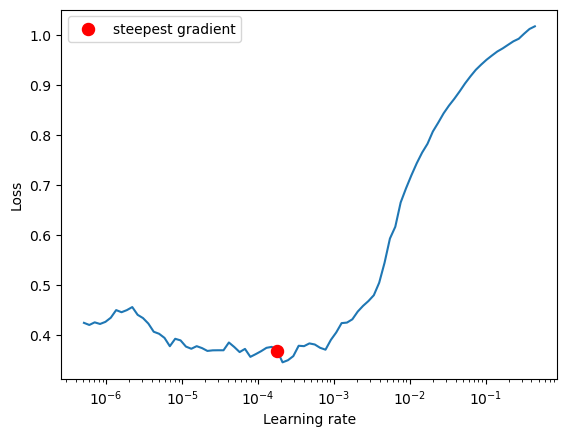



Learning rate for the next training: 0.00017886495290574345



TRAINING ITERATION 2/6

----------------------------------------

EPOCH 1/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:09.806486



EPOCH 1/12. validation step...

Results:

 - Train epoch mean loss: 0.3566

 - Valid epoch mean loss: 0.2761



 - Dice score: 0.6196

 - Iou: 45.32%

 - Pixel accuracy: 96.96%

 - Lower validation loss achieved (0.3240-->0.2761). Saving model...

----------------------------------------

EPOCH 2/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:05.392257



EPOCH 2/12. validation step...

Results:

 - Train epoch mean loss: 0.3412

 - Valid epoch mean loss: 0.2715



 - Dice score: 0.6184

 - Iou: 45.10%

 - Pixel accuracy: 96.93%

 - Lower validation loss achieved (0.2761-->0.2715). Saving model...

----------------------------------------

EPOCH 3/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:21.928554



EPOCH 3/12. validation step.

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()

LR suggestion: steepest gradient

Suggested LR: 7.92E-05


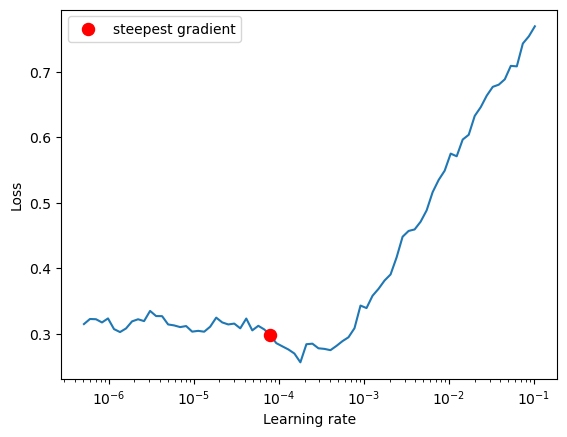



Learning rate for the next training: 7.924828983539173e-05



TRAINING ITERATION 3/6

----------------------------------------

EPOCH 1/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:21.719858



EPOCH 1/12. validation step...

Results:

 - Train epoch mean loss: 0.2740

 - Valid epoch mean loss: 0.2049



 - Dice score: 0.6441

 - Iou: 47.88%

 - Pixel accuracy: 97.09%

 - Lower validation loss achieved (0.2115-->0.2049). Saving model...

----------------------------------------

EPOCH 2/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:21.718062



EPOCH 2/12. validation step...

Results:

 - Train epoch mean loss: 0.2730

 - Valid epoch mean loss: 0.2191



 - Dice score: 0.6374

 - Iou: 47.20%

 - Pixel accuracy: 97.09%

 - Validation loss did not improved. Early stopping counter 1/3

----------------------------------------

EPOCH 3/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:12.271877



EPOCH 3/12. validation step...

Re

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()

LR suggestion: steepest gradient

Suggested LR: 1.83E-05


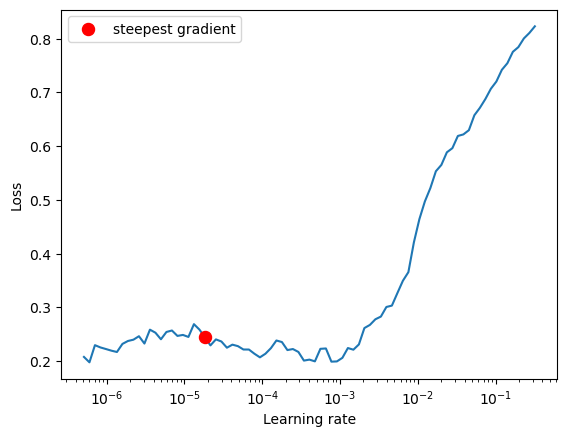



Learning rate for the next training: 1.830738280295369e-05



TRAINING ITERATION 4/6

----------------------------------------

EPOCH 1/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:13.273762



EPOCH 1/12. validation step...

Results:

 - Train epoch mean loss: 0.2737

 - Valid epoch mean loss: 0.2200



 - Dice score: 0.6379

 - Iou: 47.19%

 - Pixel accuracy: 97.12%

 - Validation loss did not improved. Early stopping counter 1/3

----------------------------------------

EPOCH 2/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:13.989778



EPOCH 2/12. validation step...

Results:

 - Train epoch mean loss: 0.2633

 - Valid epoch mean loss: 0.1995



 - Dice score: 0.6452

 - Iou: 47.97%

 - Pixel accuracy: 97.19%

 - Lower validation loss achieved (0.2049-->0.1995). Saving model...

----------------------------------------

EPOCH 3/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:17.588671



EPOCH 3/12. validation step...

Re

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()

LR suggestion: steepest gradient

Suggested LR: 5.86E-06


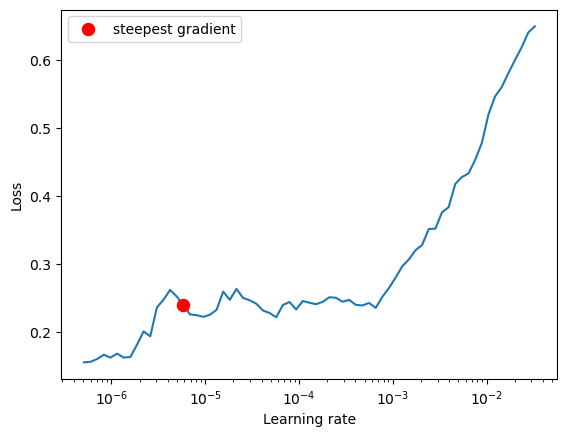



Learning rate for the next training: 5.857020818056668e-06



TRAINING ITERATION 5/6

----------------------------------------

EPOCH 1/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:16.431951



EPOCH 1/12. validation step...

Results:

 - Train epoch mean loss: 0.2671

 - Valid epoch mean loss: 0.2160



 - Dice score: 0.6389

 - Iou: 47.25%

 - Pixel accuracy: 97.07%

 - Validation loss did not improved. Early stopping counter 1/3

----------------------------------------

EPOCH 2/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:13.313661



EPOCH 2/12. validation step...

Results:

 - Train epoch mean loss: 0.2704

 - Valid epoch mean loss: 0.2072



 - Dice score: 0.6424

 - Iou: 47.68%

 - Pixel accuracy: 97.21%

 - Validation loss did not improved. Early stopping counter 2/3

----------------------------------------

EPOCH 3/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:17.281976



EPOCH 3/12. validation step...

Results

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()

LR suggestion: steepest gradient

Suggested LR: 5.09E-07


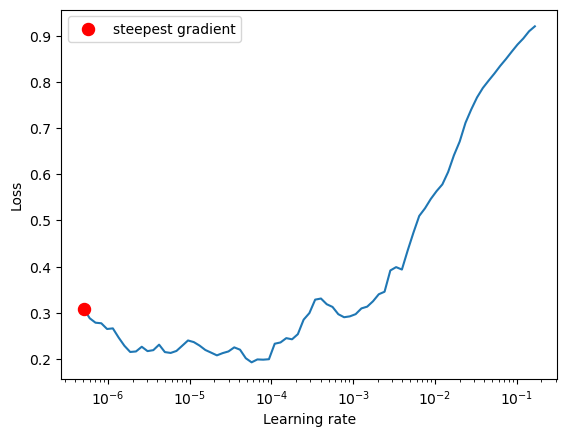

Unexpected format for suggested learning rate.



Learning rate for the next training: 0.0001



TRAINING ITERATION 6/6

----------------------------------------

EPOCH 1/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:23.170793



EPOCH 1/12. validation step...

Results:

 - Train epoch mean loss: 0.2718

 - Valid epoch mean loss: 0.2003



 - Dice score: 0.6457

 - Iou: 47.97%

 - Pixel accuracy: 97.10%

 - Validation loss did not improved. Early stopping counter 1/3

----------------------------------------

EPOCH 2/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:13.865060



EPOCH 2/12. validation step...

Results:

 - Train epoch mean loss: 0.2576

 - Valid epoch mean loss: 0.2204



 - Dice score: 0.6389

 - Iou: 47.29%

 - Pixel accuracy: 97.00%

 - Validation loss did not improved. Early stopping counter 2/3

----------------------------------------

EPOCH 3/12. training step...

 - epoch training time: (hh:mm:ss:ms): 0:02:15.384198



EPOCH 

In [12]:
loss_fn = CombinedLoss()
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=cfg.init_lr, weight_decay=cfg.weight_decay)

unet_model, history = model_trainer(
    train_loader=train_loader,
    valid_loader=val_loader,
    model=unet_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=cfg.epochs,
    early_stopping=cfg.early_stopping,
    set_scaler=cfg.mixed_precision,
    device=device,
    repeat=cfg.repeat,
)

In [13]:
mhist = pd.DataFrame(history)
mhist

epoch  train_loss  valid_loss      p_acc   d_score        iou
0       1    1.537337    1.431779  90.265357  0.322003  19.460004
1       2    1.328831    1.239894  93.172284  0.409015  26.106247
2       3    1.157916    1.044994  95.785962  0.479895  32.022417
3       4    1.000399    0.890496  95.265559  0.499631  33.704214
4       5    0.852089    0.709123  95.834954  0.535250  36.890110
5       6    0.707462    0.663852  96.453513  0.532969  36.842945
6       7    0.599606    0.529413  96.524511  0.544709  38.042566
7       8    0.542334    0.536615  95.904023  0.539137  37.396314
8       9    0.503135    0.438462  96.454274  0.565799  39.921412
9      10    0.482407    0.371705  96.594841  0.586185  41.896193
10     11    0.425417    0.414508  96.632761  0.562763  39.762255
11     12    0.424052    0.323977  96.781328  0.601407  43.468408
12      1    0.356606    0.276064  96.958495  0.619591  45.315936
13      2    0.341219    0.271524  96.925031  0.618404  45.100257
14      3    0.327435    0.258524  96.864546  0.625001  45.770984
15      4    0.319719    0.236536  96.949630  0.634616  46.808650
16      5    0.310537    0.256706  96.918695  0.626151  45.969097
17      6    0.297273    0.231687  96.986985  0.633986  46.801180
18      7    0.289244    0.228969  97.142328  0.634176  46.836681
19      8    0.279140    0.231712  97.027504  0.633677  46.716791
20      9    0.283291    0.211476  97.062466  0.643042  47.663258
21     10    0.292438    0.219836  97.110382  0.639313  47.262945
22     11    0.281231    0.232796  96.952235  0.633538  46.700625
23     12    0.279586    0.228044  97.095262  0.632926  46.670867
24      1    0.274027    0.204946  97.094651  0.644141  47.882389
25      2    0.273010    0.219073  97.085111  0.637391  47.198041
26      3    0.269980    0.226910  96.928285  0.636432  47.024877
27      4    0.263226    0.214881  97.114483  0.639954  47.369752
28      1    0.273669    0.220028  97.116470  0.637860  47.188840
29      2    0.263341    0.199548  97.186525  0.645152  47.966269
30      3    0.267444    0.191646  97.130786  0.649681  48.426352
31      4    0.277016    0.230771  96.985965  0.633708  46.803805
32      5    0.265366    0.200031  97.175034  0.645016  47.981319
33      6    0.253776    0.212133  97.014606  0.643297  47.691682
34      1    0.267142    0.216018  97.066162  0.638880  47.246045
35      2    0.270381    0.207247  97.205819  0.642409  47.678333
36      3    0.265441    0.208319  97.061039  0.641658  47.640804
37      1    0.271788    0.200343  97.097897  0.645671  47.967352
38      2    0.257621    0.220367  97.001307  0.638939  47.290624
39      3    0.272137    0.212756  97.151524  0.639261  47.266188

In [24]:
# best dice score
best_dice = mhist.loc[(mhist['valid_loss'] == min(mhist['valid_loss']))]['d_score']
bd_index = best_dice.index.item()
bd_value = best_dice.item()
print(f'Best dice score {bd_value:.4f} ({bd_index}. row)')

Best dice score 0.6497 (30. row)


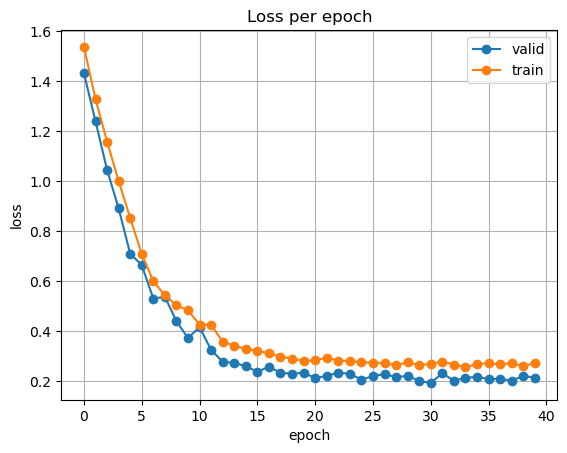

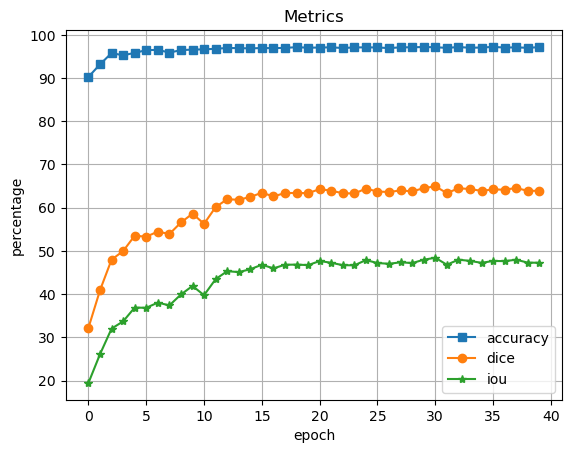

In [25]:
def plot_loss(history):
    plt.plot(history['valid_loss'], label='valid', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

def plot_metrics(history):
    plt.plot(history['p_acc'], label='accuracy', marker='s')
    plt.plot(history['d_score']*100, label='dice', marker='o')
    plt.plot(history['iou'], label='iou', marker='*')
    plt.title('Metrics')
    plt.ylabel('percentage')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

    
plot_loss(mhist)
plot_metrics(mhist)

## Inference

In [26]:
def predict_on_batch(batch_of_data, eval_model, model_name="", threshold=0.5):

    for img, lbl, imid in zip(batch_of_data[0], batch_of_data[1], batch_of_data[2]):
        img = img.to(device)
        lbl = lbl.to(device)

        img_to_pred = torch.unsqueeze(img, 0).to(torch.float32)
        pred_probs = torch.sigmoid(eval_model(img_to_pred)).squeeze(0)
        pred_class = (pred_probs > threshold).float()
        
        ## Metrics
        dice, iou, pa = calc_stats(pred_class, lbl)
       
        ## Visualize
        pred_probs = pred_probs.detach().cpu().numpy().swapaxes(0, -1)        
        pred_class = pred_class.cpu().numpy().swapaxes(0, -1)
        image = img.cpu().numpy().swapaxes(0, -1)
        label = lbl.cpu().numpy().swapaxes(0, -1)
        print(f"Metrics of {imid}:")
#         print(f"- pixel accuracy: {pa:.2f}%")
        print(f"- iou: {iou:.2f}%")
        print(f"- dice score: {dice:.2f}")
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 7))
        axs[0].imshow(image)
        axs[0].imshow(label, alpha=0.5)
        axs[0].set_title("Mask & image")
        axs[1].imshow(image)
        axs[1].imshow(pred_class, alpha=0.5)
        axs[1].set_title(f"Binary preds ({threshold})")
        axs[1].set_axis_off()
        plt.show()

Metrics of 1222b4306c01:

- iou: 67.31%

- dice score: 0.80


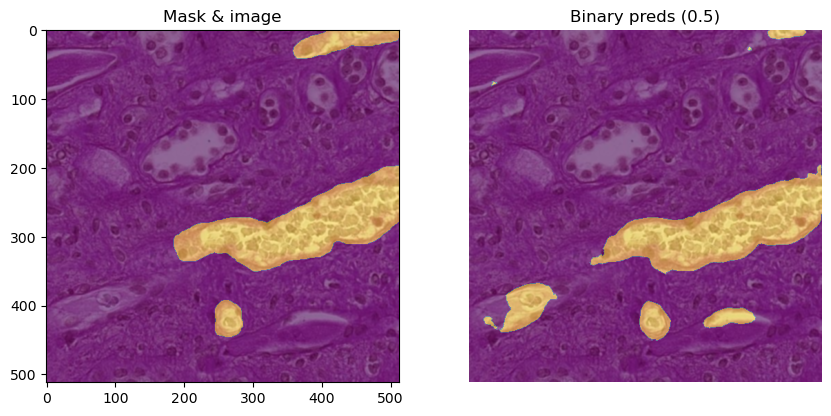

Metrics of e37d89a19566:

- iou: 38.39%

- dice score: 0.55


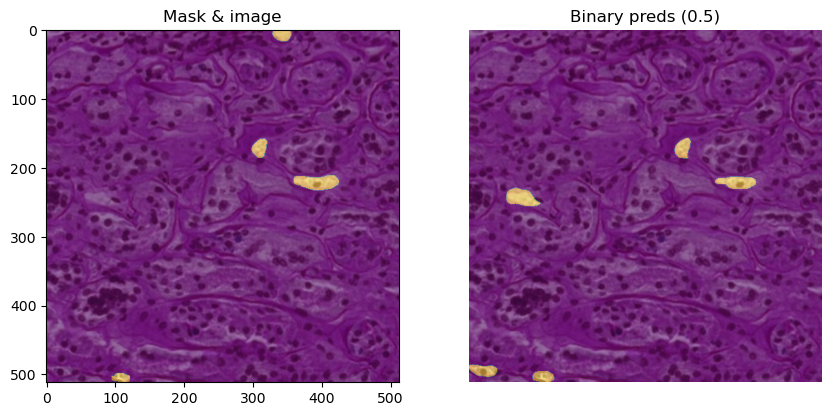

Metrics of 055348e2fece:

- iou: 2.87%

- dice score: 0.06


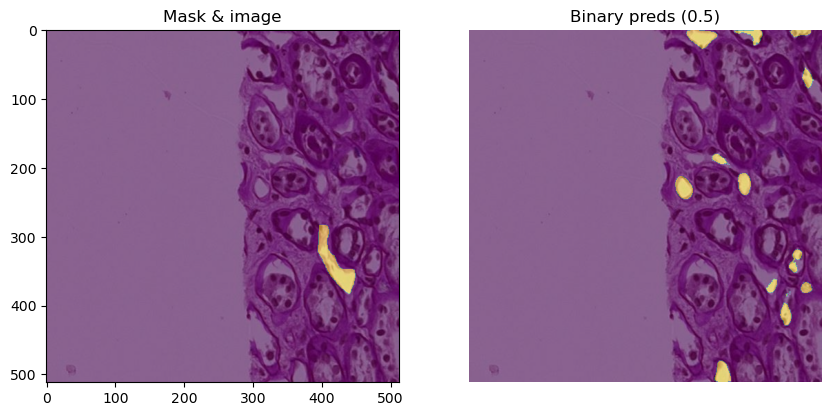

Metrics of 9afac4fc65ef:

- iou: 58.21%

- dice score: 0.74


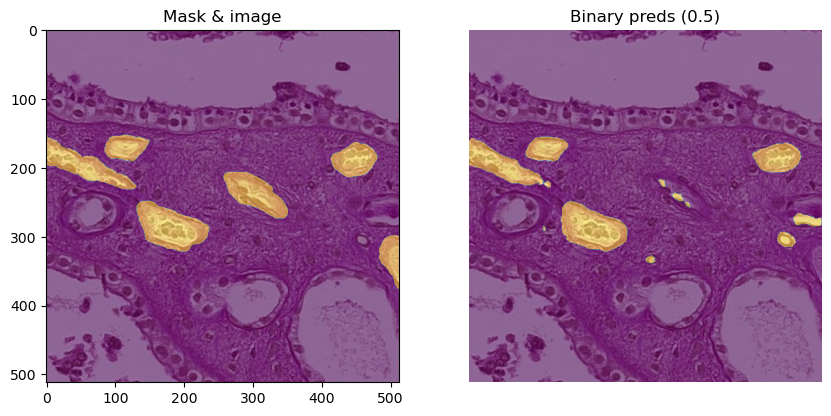

Metrics of 564283be4af8:

- iou: 24.34%

- dice score: 0.39


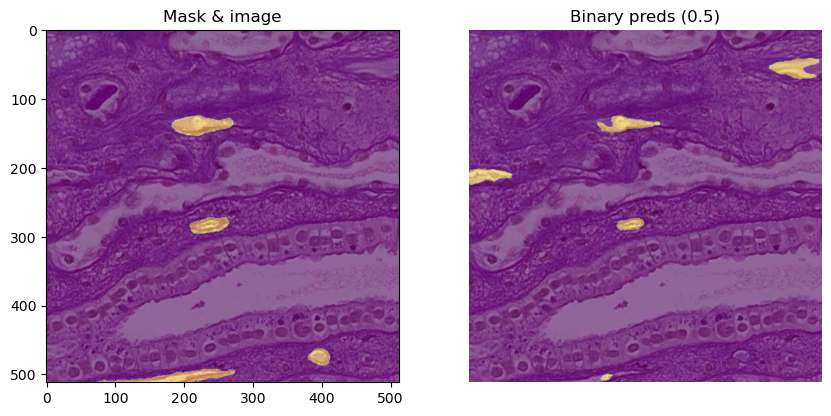

Metrics of 1a91d04d00d5:

- iou: 47.06%

- dice score: 0.64


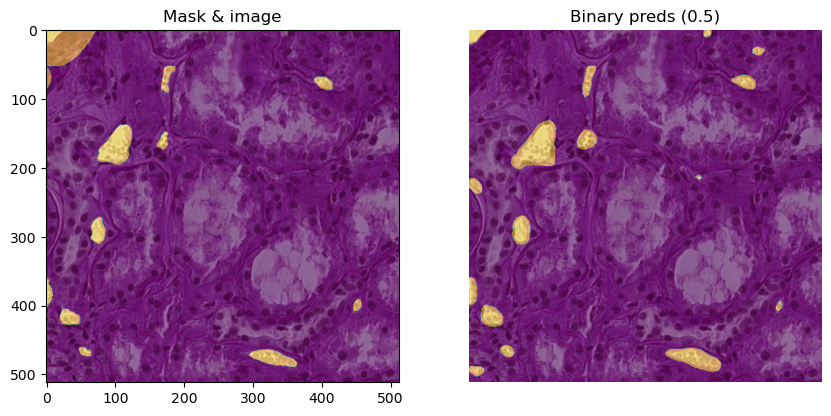

Metrics of 8565f71a4149:

- iou: 58.98%

- dice score: 0.74


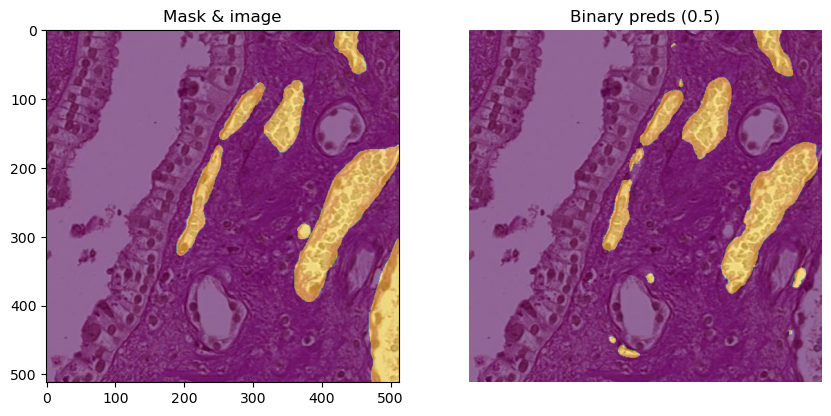

Metrics of 2e00a0fe807c:

- iou: 59.93%

- dice score: 0.75


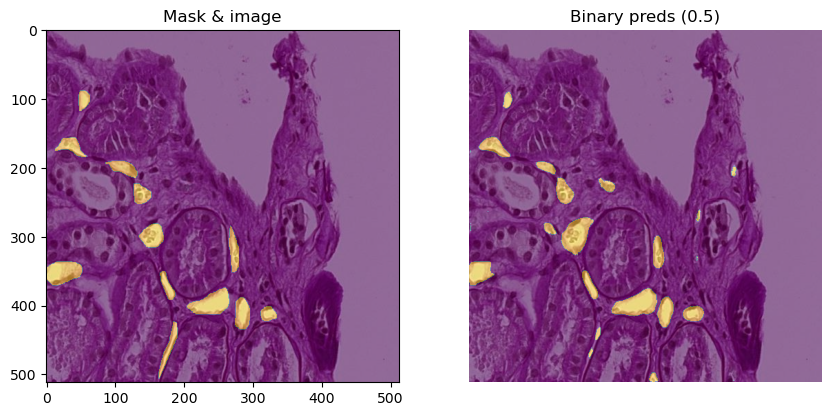

Metrics of 5715f8aaf551:

- iou: 38.97%

- dice score: 0.56


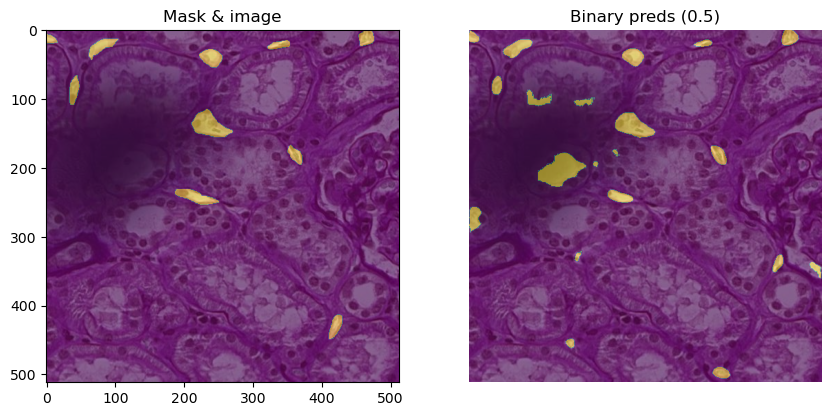

Metrics of 66f49941ae3a:

- iou: 46.10%

- dice score: 0.63


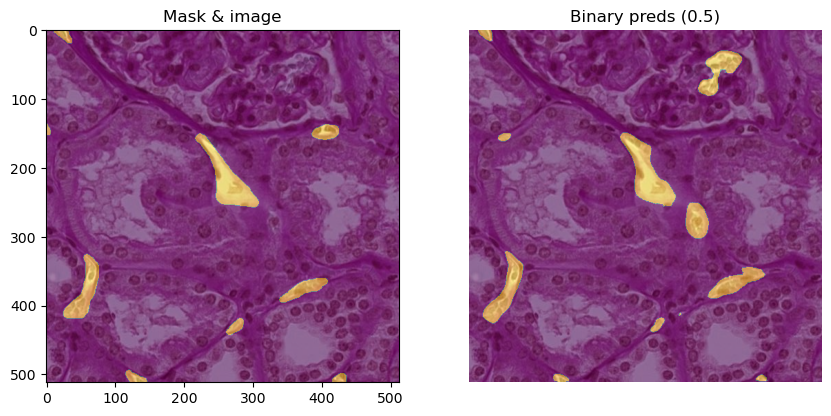

Metrics of f81fafbae0e6:

- iou: 4.61%

- dice score: 0.09


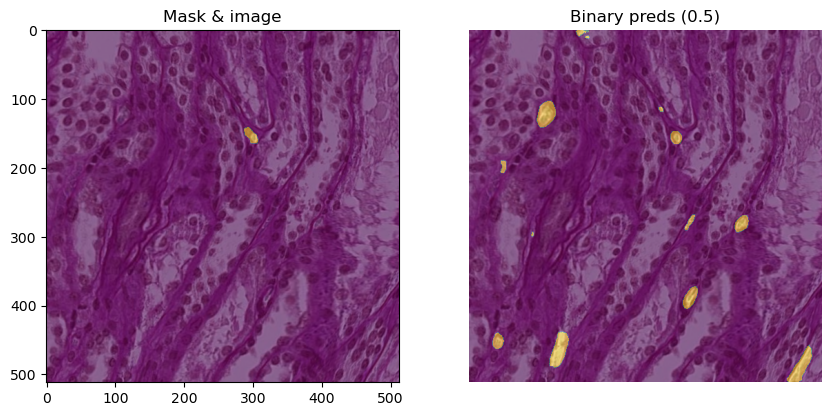

Metrics of 4a06a2773c1d:

- iou: 73.09%

- dice score: 0.84


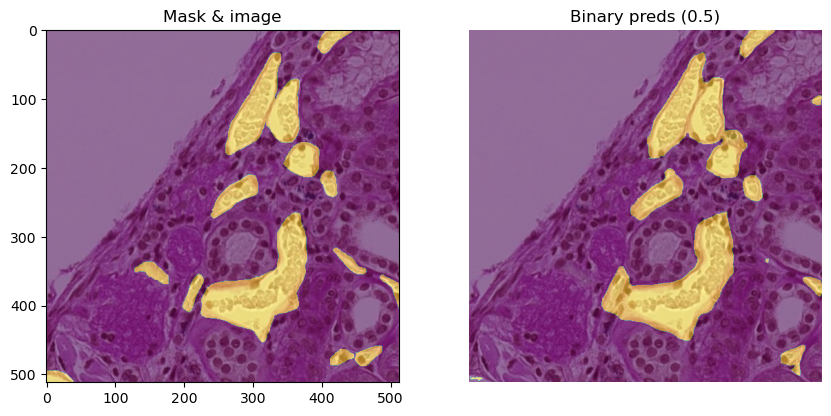

Metrics of 83db373faecc:

- iou: 60.46%

- dice score: 0.75


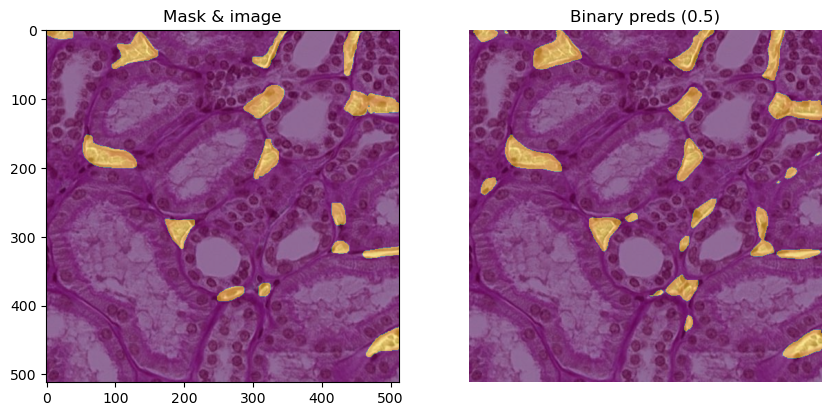

Metrics of 97dce4548ae2:

- iou: 34.33%

- dice score: 0.51


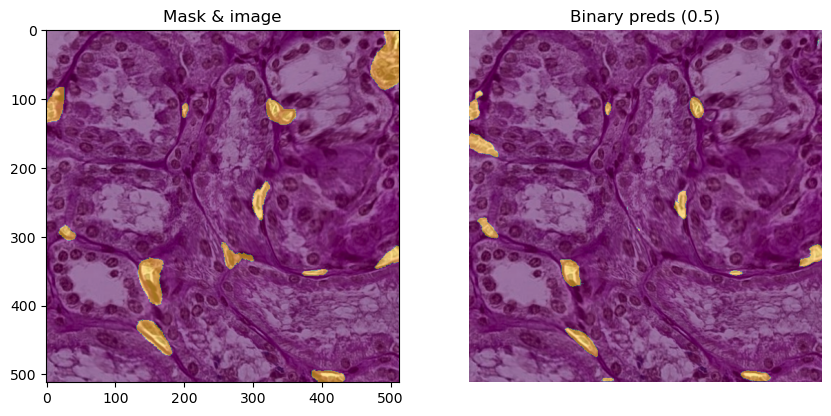

Metrics of 67a098bcc9bf:

- iou: 62.70%

- dice score: 0.77


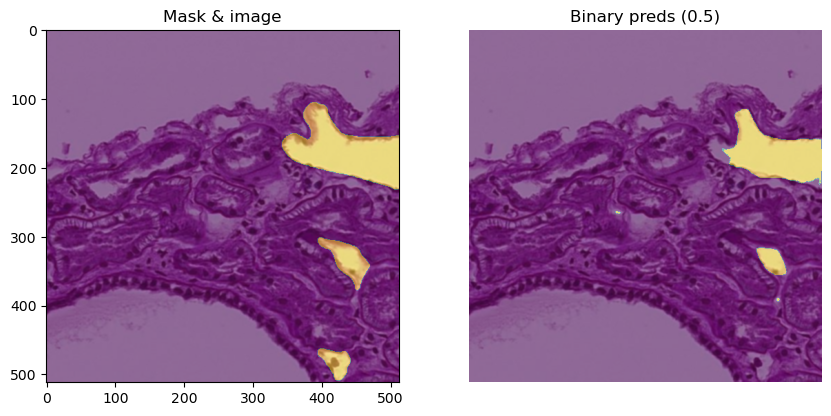

Metrics of 620901cb76b3:

- iou: 9.63%

- dice score: 0.18


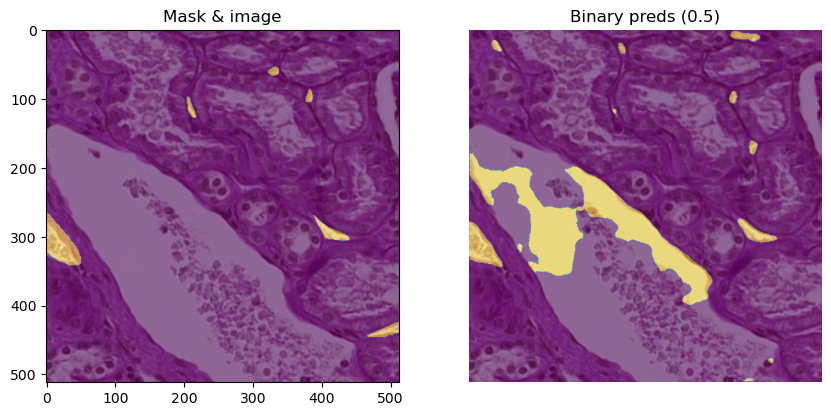

In [27]:
## Run infernce and visualize
best_model_path = "./best_model_state.pth"
inf_model = UNet(in_filters=cfg.filters, num_classes=cfg.num_classes)
inf_model.load_state_dict(torch.load(best_model_path))
inf_model.eval().to(device)

itera = iter(val_loader)
vbatch_1 = next(itera)
vbatch_2 = next(itera)
predict_on_batch(vbatch_1, inf_model, threshold=0.5)
predict_on_batch(vbatch_2, inf_model, threshold=0.5)
